### Teoría

1. **Considere un escenario de una ciudad con:**<br>
    - **Modelo temporal: Tiempo continuo (infecciones impulsadas por eventos)**<br>
    - **Distribución de rasgos: 20% de personas mayores (alto riesgo), 30% de trabajadores esenciales (alta movilidad)**

**Responder:**
- **¿Cómo podría la iteracción del modelo temporal y la distribución de rasgos amplificar los brotes en residencias de ancianos?**<br>
El tiempo continuo permite que varios contagios ocurran en pocas horas. La alta movilidad de los trabajadores esenciales hacen que la enfermedad se propague más rápido y los ancianos ofrecen una gran cadena de propagación, pues son de alto riesgo.

- **¿Podría el modelado de tiempo discreto ocultar esta dinámica? ¿Por qué?**<br>
Si, porque al ser discretos los contagios simultáneos podrían llegar a agruparse. Esto hace ver rachas de infección más suavez de lo que realmente son, ocultando la rapidez real del brote.

2. **Considere las curvas de infección simuladas que muestren picos repentinos en barrios de bajos ingresos, con ello responda**<br>
**_a_. Identifique dos objetivos de calibración para validar**<br>
- **Tiempo de eventos (p. ej. Intervalos de infección)**<br>
Objetivo 1: reproducir la duración del pico epidémico en barrios afectados.<br>
Objetivo 2: ajustar la velocidad de ascenso y descenso de las curvas simuladas.

- **Resultados dependientes de rasgos (p. ej. Tasas de casos por ingresos)**<br>
Objetivo 1: validar la proporción de hospitalizaciones en barrios de bajos ingresos.<br>
Objetivo 2: reproducir la tasa de reinfecciones o recurrencias según nivel socioeconómico.

**_b_. Responda: ¿Cómo distinguiría entre artefactos del modelo y desigualdades reales?**
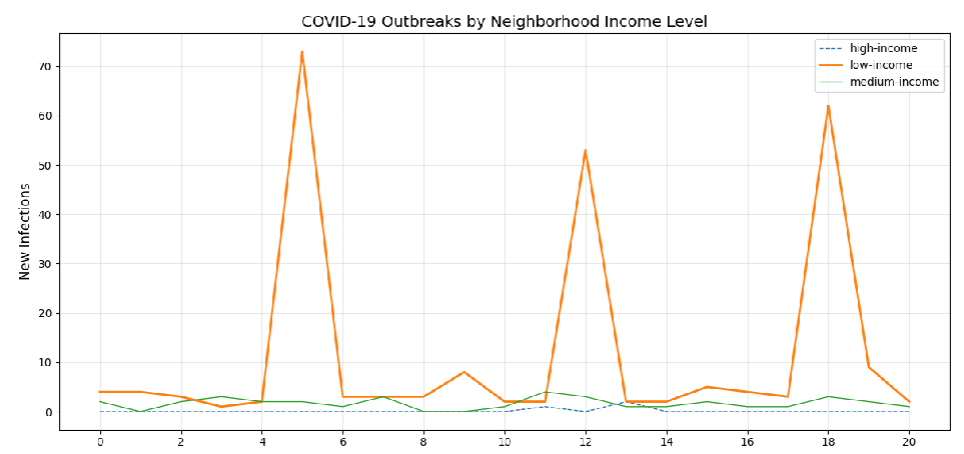
Se podrían comparar los datos con los de epidemias previas (o reales), para ver si los patrones son parecidos o si hay un comportamiento distinto. También se podría ver si dentro del modelo, ese tipo de picos se mantienen al cambiar parámetros. 


### Práctica

In [ ]:
# 1. Reglas

# Estructuras
Agent:
  id, age, is_health_worker, is_teacher    # id único y atributos básicos
  risk_score -> [0,10]                     # continuo
  access_level -> {1,2,3}                  # nivel de acceso a vacuna siendo 1 el más alto y 3 el más bajo
  distance_km, hesitancy_p                 # distancia al centro de vacunación y probabilidad de rechazo
  status -> {unvax, dose1, dose2}          # estado de vacunación

Event: (time, key, type, agent_id, meta)  # evento con tiempo, clave de prioridad, tipo, id del agente y metadatos (como dosis)

# Prioridad base
# Define capas de prioridad base según características del agente
# 0 es el más alto, 3 el más bajo
function base_priority(agent):
  if agent.is_health_worker: return 0
  if agent.age ≥ 65:         return 1
  if agent.is_teacher:       return 2
  return 3                   # resto

# Resolución de conflictos
# Normaliza el riesgo y calcula la clave de prioridad
function priority_key(agent, wait_time):
  return ( base_priority(agent),
           -normalize(agent.risk_score),  # mayor riesgo = más prioridad
           agent.access_level,            # 1 antes que 2, antes que 3
           -wait_time )                   # más espera = sube en la cola

# Programar intento de vacunación
# Programa un evento de vacunación basado en el agente y el tiempo actual
function schedule_vaccine(agent, now):
  wait_time = time_since_first_request(agent)
  key = priority_key(agent, wait_time)
  push(EventQueue, Event(now, key, "VACCINE_REQUEST", agent.id, {}))


**¿Cómo gestionaría los conflictos (p. ej., un docente que también es mayor)?**<br>
Se resuelven mediante un orden lexicográfico. En este, primero es por grupo (sanitario > edad > docente). Luego es riesgo continuo y por último el nivel de acceso. No importa que solo cumpla con más de uno de los criterios de cada grupo, ya que solo se tomará en cuenta el de mayor prioridad. 

In [ ]:
# 2. Subpoblaciones

# Definición de tres subpoblaciones
Subpop A: Seniors (age ≥ 65)                                # Mayores de 65 años
  risk_score ~ TruncatedNormal(μ=7.5, σ=1.5, [0,10])
  access_level ~ Categorical(p=[0.3, 0.4, 0.3])   # 1,2,3

Subpop B: Health workers                                    # Trabajadores de la salud
  risk_score ~ TruncatedNormal(μ=6.5, σ=1.5, [0,10])
  access_level ~ Categorical(p=[0.6, 0.3, 0.1])

Subpop C: Teachers                                          # Docentes
  risk_score ~ TruncatedNormal(μ=5.5, σ=1.5, [0,10])
  access_level ~ Categorical(p=[0.5, 0.35, 0.15])


**Proponer un método de muestreo para garantizar que los grupos minoritarios no estén
infrarrepresentados.**<br>
Hacer un muestreo por subpoblación y nivel de acceso, dando cuota mínima por estrato y sobremuestreo de estatos pequeños. Después de esto se puede aplicar una ponderación que estime métricas que mantengan la imparcialidad.

In [ ]:
# Sistema de registro

# registra eventos de vacunación en un log inmutable
VaccinationLog fields:
  timestamp, event_type, agent_id, subpop, priority_group,         # datos del evento
  access_level, risk_score, clinic_id, dose_number,                # datos del agente
  state -> {requested, scheduled, administered, no_show, refused}  # estado del evento

# Agrega un registro del evento nuevo sin sobreescribir los anteriores
function register(event, meta):
  append(VaccinationLog, {...})

# Ejemplos de eventos
# Solicitud de vacuna
on "VACCINE_REQUEST"(agent):
  register(now, requested, agent, ...)
  if slot_available(agent):
     schedule(Event(now+queue_delay, key, "ADMINISTER_DOSE", agent.id, {dose=1}))
     register(now, scheduled, agent, ...)
  else
     put_in_waitlist(agent)

# Administración de dosis
on "ADMINISTER_DOSE"(agent, dose=1):
  if not hesitant(agent):
     agent.status = dose1
     register(now, administered(dose=1), agent, ...)
     schedule(Event(now + interval_dose2, key2, "ADMINISTER_DOSE", agent.id, {dose=2}))
  else
     register(now, refused, agent, ...)


**¿Qué visualización revelaría mejor las disparidades de acceso (p. ej., mapas de calor,
curvas de Lorenz)?**<br>
La curva de Lorenz de dosis acumulada vs población acumulada ordenada por nivel de acceso y distancia sería la mejor. Esta mostraría de forma directa la desigualdad en la asignación.

In [ ]:
# Bucle principal

initialize_population(N, subpop distributions)                                                        # Inicializa la población con N agentes según las distribuciones de subpoblación
initialize_clinics(capacity_per_day, location)                                                        # Inicializa clínicas con capacidad diaria y ubicación
seed EventQueue with VACCINE_REQUEST for all agents at t ~ arrival_process(access, hesitancy)         # Programa eventos de solicitud de vacuna para todos los agentes

while EventQueue not empty and now ≤ T_end:
  ev = pop_min(EventQueue)        # ordena por tiempo y prioridad
  now = ev.time                   # actualiza el tiempo
  handle(ev)                      # maneja el evento según su tipo


**¿Cómo las interacciones rasgo-tiempo podrían sesgar las recomendaciones de políticas?**<br>
Los grupos con alto acceso y menor reticencia reciben antes, por lo que si se asignan dosis según una "demanda reciente" se estaría reforzando a la desigualdad. Además, las ventanas de evaluación cortas capturan en su mayoria a grupos de respuesta rápida, lo que también genera sesgo, pues hace ver como que la oferta de vacunas es buena cuando aún existen grupos sin acceso a ellas. 

## Ejercicio 4

**Considere un escenario con 1M de agentes con:**
- **Versión homogénea: 3 rasgos (idénticos para todos los agentes)**
- **Versión heterogénea: 5 rasgos únicos por agente**

**Responda:**
- **Calcule y compare los requisitos de memoria para ambas versiones**<br>
Suponiendo que cada rasgo continuó/categórico está codificado en 4 bytes.<br>
Homogenea:<br>
se guarda una sola vez, pues es el mismo dato, por lo que solo se guardaría en un espacio. 4 bytes totales.<br>
Heterogénea:<br>
se guarda cada rasgo por separado por agente. 4x5 = 20 bytes totales.

- **Identifique qué rasgos de los agentes podrían simplificarse de forma segura para mejorar el rendimiento sin perder dinámicas críticas**<br>
Se pueden simplificar el riesgo continuo si solo se usa para umbrales. También se puede simplificar la accesibilidad si solo importa por rangos, por ejemplo 1-5km o 1-3km.También se puede simplificar la probabilidad de dar la vacuna si es que es un valor siemrpe fijo, lo mismo con los nombres de algunas categorias como ocupación y grupo prioritario. 
